In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from scipy import stats
import scanpy as sc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
import shap

In [2]:
#Import dataset1
global_dir_path = "C://Users/chris/OneDrive/Desktop/MIT postdoc project/ABN project/Lung cancer/Headspace_data"

In [3]:
def plot_roc(y_test, y_pred): 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(3.2, 3),dpi = 160)
    plt.rc('font', family='Arial')
    plt.plot(fpr, tpr, color='black', lw=1.5, label='Endogenous (AUC: %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, lw=1, label='Random classifier')

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xlabel('1 - Specificity', fontsize=13, labelpad=7)
    plt.ylabel('Sensitivity', fontsize=13, labelpad=7)
    plt.legend(bbox_to_anchor=(0.15, 0.22), loc='best', facecolor="None", edgecolor="None", fontsize = 10)

    plt.show()

In [4]:
def plot_cm(y_test, y_pred): 
    fig, ax = plt.subplots(figsize=(3, 3),dpi = 160)
    plt.rc('font', family='Arial')
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Healthy', 'Cancer'],cmap=plt.cm.Reds, ax=ax)
    plt.rcParams.update({'font.size': 11})
    
    label_font = {'size':'12'}
    ax.set_xlabel('Predicted labels', fontdict=label_font, labelpad=7);
    ax.set_ylabel('True labels', fontdict=label_font, labelpad=7);

In [5]:
#4wks
dir_path = global_dir_path + '/2023_0809_0810_Breath_Eml4Alk_4wks_multiplex/Spectra/Peaks/Int_ratio_r1'
dir_path2 = global_dir_path + '/2023_10_19_Breath_Eml4Alk_4wk_5plex/Spectra/Peaks/Int_ratio_r1'

#5wks
dir_path3 = global_dir_path + '/2023_0816_0817_Breath_Eml4Alk_5wks_multiplex/All samples_spectra/Peaks/Int_ratio_r1'
dir_path4 = global_dir_path + '/2023_10_26_Breath_Eml4Alk_5wks_cohort2/spectra/Peaks/Int_ratio_r1'
dir_path5 = global_dir_path + '/2024_02_09_Eml4-Alk_5wks_multiplex/Spectra/Peaks/Int_ratio_r1'

#6wks
#August
# dir_path6 = global_dir_path + '/2023_08_24_Breath_EmlAlk_6wks_multiplex/Spectra/Peaks/Int_ratio_r1'
#October
# dir_path7 = global_dir_path + '/2023_10_23_Breath_Eml4-Alk_6wks_cohort1/spectra/Peaks/Int_ratio_r1'
#May
# dir_path8 = global_dir_path + '/2023_May_June_Eml4Alk_6to8wks_spectra/2023_05_19_Breath_Eml4Alk_6wks_calibrated_spectra/Peaks/Int_ratio_r1'
#Jan2024
dir_path9 = global_dir_path + '/2024_0116_0117_Breath_Eml4aLK_6w_endo/Peaks/Int_ratio_r1'
dir_path10 = global_dir_path + '/2024_02_16_Eml4Alk_6wks_multiplex/spectra/Peaks/Int_ratio_r1'

In [11]:
#import excel file using panda as df
name = dir_path + '/zscore.xlsx'
name2 = dir_path2 + '/zscore.xlsx'
name3 = dir_path3 + '/zscore.xlsx'
name4 = dir_path4 + '/zscore.xlsx'
name5 = dir_path5 + '/zscore.xlsx'
# name6 = dir_path6 + '/zscore.xlsx'
# name7 = dir_path7 + '/zscore.xlsx'
# name8 = dir_path8 + '/zscore.xlsx'
name9 = dir_path9 + '/zscore.xlsx'
name10 = dir_path10 + '/zscore.xlsx'

df = pd.read_excel(name)
df2 = pd.read_excel(name2)
df3 = pd.read_excel(name3)
df4 = pd.read_excel(name4)
df5 = pd.read_excel(name5)
# df6 = pd.read_excel(name6)
# df7 = pd.read_excel(name7)
# df8 = pd.read_excel(name8)
df9 = pd.read_excel(name9)
df10 = pd.read_excel(name10)

In [12]:
df_all = pd.concat([df, df2, df3, df4, df5, df9, df10], axis=0, ignore_index=True)

type_all = df_all.iloc[:,1]

def astype(type_wk): 
    astype_wk = []
    for i in type_wk:
        if 'H' in i:
            astype_wk.append(0)
        elif 'C' in i:
            astype_wk.append(1)
    
    return astype_wk

astype_all = astype(type_all)

print(astype_all)
print(len(astype_all))

[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
146


In [13]:
#drop columns that contain NaN in a new dataset
df2_all = df_all.copy()

def droplist(df): 
    drop_col = []
    for col in df.columns: 
        nan = df[col].isna()
        for i in nan: 
            if i == True:
                drop_col.append(col)
                break
    return drop_col

drop_all = droplist(df2_all)

df2_all = df2_all.drop(drop_all, axis=1)

In [14]:
colnum_all = len(df2_all.columns) 
ns_all = df2_all.iloc[:,2:colnum_all]
ns_all = ns_all.to_numpy()
print(colnum_all)

185


In [15]:
X_train, X_test, y_train, y_test = train_test_split(ns_all, astype_all, test_size=0.35, random_state=0, shuffle=True)

In [16]:
param_dist = {'max_depth' : [1, 2, 3, 5, 10, 15, 20],
              'min_samples_leaf' : [1, 2, 3, 4], 
              'random_state' : [0, 42],
              'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             'max_features' : [0.2, 0.4, 0.6, 'log2', 'sqrt', 'None']}

clf = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_dist,
                                n_iter=50)

In [17]:
# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_clf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

KeyboardInterrupt: 

In [18]:
#df1-5, df9, df10, split=0.4
# clf = GradientBoostingClassifier(n_estimators=1000, max_depth=10,
#                                  max_features = 0.2, criterion= 'friedman_mse',
#                                  random_state=42, min_samples_leaf=2,
#                                  learning_rate=0.4).fit(X_train, y_train)

#df1-5, df9, df10, split=0.35
clf = GradientBoostingClassifier(n_estimators=1000, max_depth=5,
                                 max_features = 0.2, criterion= 'friedman_mse',
                                 random_state=42, min_samples_leaf=2,
                                 learning_rate=0.4).fit(X_train, y_train)

#add df6
# clf = GradientBoostingClassifier(n_estimators=1000, max_depth=15,
#                                  max_features = 0.6, criterion= 'friedman_mse',
#                                  random_state=42, min_samples_leaf=1,
#                                  learning_rate=0.1).fit(X_train, y_train)

#add df6 and df8
# clf = GradientBoostingClassifier(n_estimators=1000, max_depth=20,
#                                  max_features = 0.4, criterion= 'friedman_mse',
#                                  random_state=42, min_samples_leaf=2,
#                                  learning_rate=0.4).fit(X_train, y_train)

#add df6, df7, df8
# clf = GradientBoostingClassifier(n_estimators=1000, max_depth=10,
#                                  max_features = 0.1, criterion= 'friedman_mse',
#                                  random_state=42, min_samples_leaf=2,
#                                  learning_rate=0.6).fit(X_train, y_train)

In [19]:
y_pred = clf.predict(X_test)
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_pred, y_test))

ACCURACY OF THE MODEL:  0.6730769230769231
              precision    recall  f1-score   support

           0       0.40      0.62      0.48        13
           1       0.84      0.69      0.76        39

    accuracy                           0.67        52
   macro avg       0.62      0.65      0.62        52
weighted avg       0.73      0.67      0.69        52



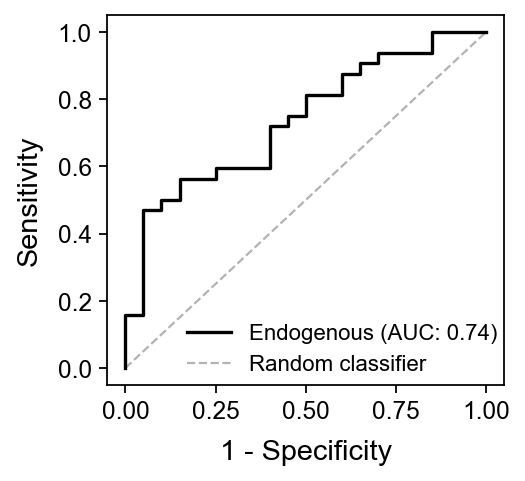

In [20]:
y_pred = clf.predict_proba(X_test)[:,1]
plot_roc(y_test, y_pred)

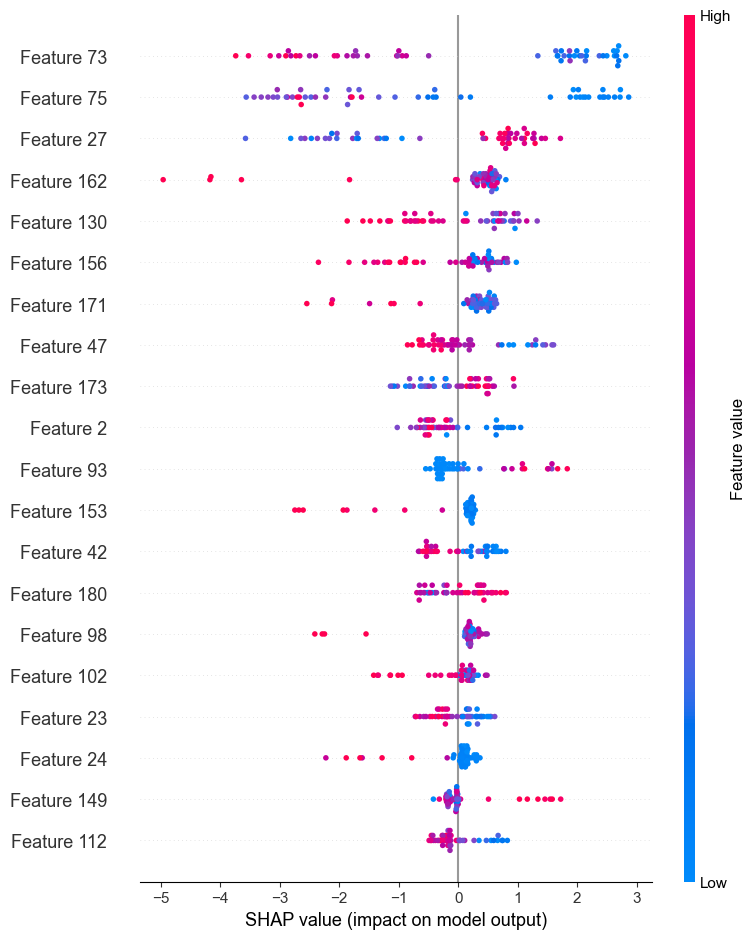

In [22]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [23]:
feature_names = [f"{i}" for i in range(ns_all.shape[1])]
feature_mz = []
for i in feature_names:
    feature_mz.append(df2_all.columns[int(i)+2])

In [24]:
importance = pd.DataFrame(shap_values, columns = feature_names)
vals = np.abs(importance.values).mean(0)

In [25]:
shap_importance = pd.DataFrame(list(zip(feature_mz, vals)),
                                  columns=['m/z','feature_vals'])
shap_importance.sort_values(by=['feature_vals'],
                               ascending=False, inplace=True)
shap_importance.head(20)

,m/z,feature_vals
73,105.1,2.130189
75,107.1,2.121879
27,66.9,1.350367
162,168.0,0.783916
130,141.0,0.764009
156,164.8,0.664796
171,182.0,0.564048
47,85.0,0.506774
173,183.0,0.482876
2,34.0,0.481763


In [ ]:
# build a Permutation explainer and explain the model predictions on the given dataset
#probably just use the SHAP values instead of the permutation
explainer = shap.explainers.Permutation(clf.predict_proba, X_test)
shap_values = explainer(X_test)

# get just the explanations for the positive class
shap_values = shap_values[..., 1]

In [ ]:
shap.summary_plot(shap_values, X_test)
shap.plots.bar(shap_values)

In [ ]:
import time
from sklearn.inspection import permutation_importance

In [ ]:
start_time = time.time()
result_clf = permutation_importance(
    clf, X_test, y_test, n_repeats=5000, random_state=0, n_jobs=2)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

importances_clf = pd.Series(result_clf.importances_mean, index=feature_mz)

In [ ]:
top20_clf = importances_clf.nlargest(20)
print(top20_clf)

In [ ]:
top10_clf = top10_clf.sort_values(ascending=False)

#Shortened version
feature_id = ['Benzylaldehyde (107)', 'Styrene (105)', 'Methanol (33)', 'Eugenol (165)',
              'Benzophenone (183)', 'Butylbenzene (135)', 'Ethanol (47)', 
              'Octanal (129)', 'Propyl acetate (103)',
              '4-Hydroxyhexanal (117)','Octanal (129)',
              'Benzene (79)','Benzoic acid (123)', 'Dimethyl-butadiene (83)', 
              '(E)-2-heptenal/octene (113)']

#feature_id = ['Xylenes (107)', 'Styrene (105)', 'Methanol (33)', 'Eugenol (165)',
#               'Benzophenone (183)', 'Butylbenzene/2-ethyl-p-xylene/2-(2-ethoxyethoxy)-ethanol (135)',
#               'Ethanol (47)','Octanal (129)', 'Propyl acetate (103)',
#               '4-Hydroxyhexanal (117)','Octanal (129)',
#               'Benzene (79)', 'Benzoic acid/xylenol (123)', 'dimethyl-butadiene/hexadiene (83)', 
#               '(E)-2-heptenal/octene (113)']

#butylbenzene and 2-ethyl-p-xylene has the same chemical formula
#eugenol and benzophenone from skin

importance = []
for i in top10_rf.values:
    importance.append(i)

fig, ax = plt.subplots(figsize =(6,5), dpi=160)
ax.barh(feature_id, importance, color='silver', edgecolor='black', label='Endogenous (W4+W5+W6)')
ax.invert_yaxis()

plt.rc('font', family='Arial')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Importance", fontsize=18, labelpad=7)
# plt.ylabel("Top 10 features", fontsize=13, labelpad=7)
plt.legend(bbox_to_anchor=(0.27, 0.16), loc='best', facecolor="None", edgecolor="None", fontsize = 15)
    
plt.show()